In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
!pip install scorecardpy

In [61]:
import scorecardpy as sc

In [62]:
# Load the dataset (replace 'path_to_your_data.csv' with your actual file path)
df = pd.read_csv('/content/Credit_Risk_Model.csv')

In [63]:
df

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95657,TransactionId_89881,BatchId_96668,AccountId_4841,SubscriptionId_3829,CustomerId_3078,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-1000.0,1000,2019-02-13T09:54:09Z,2,0
95658,TransactionId_91597,BatchId_3503,AccountId_3439,SubscriptionId_2643,CustomerId_3874,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2019-02-13T09:54:25Z,2,0
95659,TransactionId_82501,BatchId_118602,AccountId_4841,SubscriptionId_3829,CustomerId_3874,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2019-02-13T09:54:35Z,2,0
95660,TransactionId_136354,BatchId_70924,AccountId_1346,SubscriptionId_652,CustomerId_1709,UGX,256,ProviderId_6,ProductId_19,tv,ChannelId_3,3000.0,3000,2019-02-13T10:01:10Z,2,0


#Constructing a Default Estimator

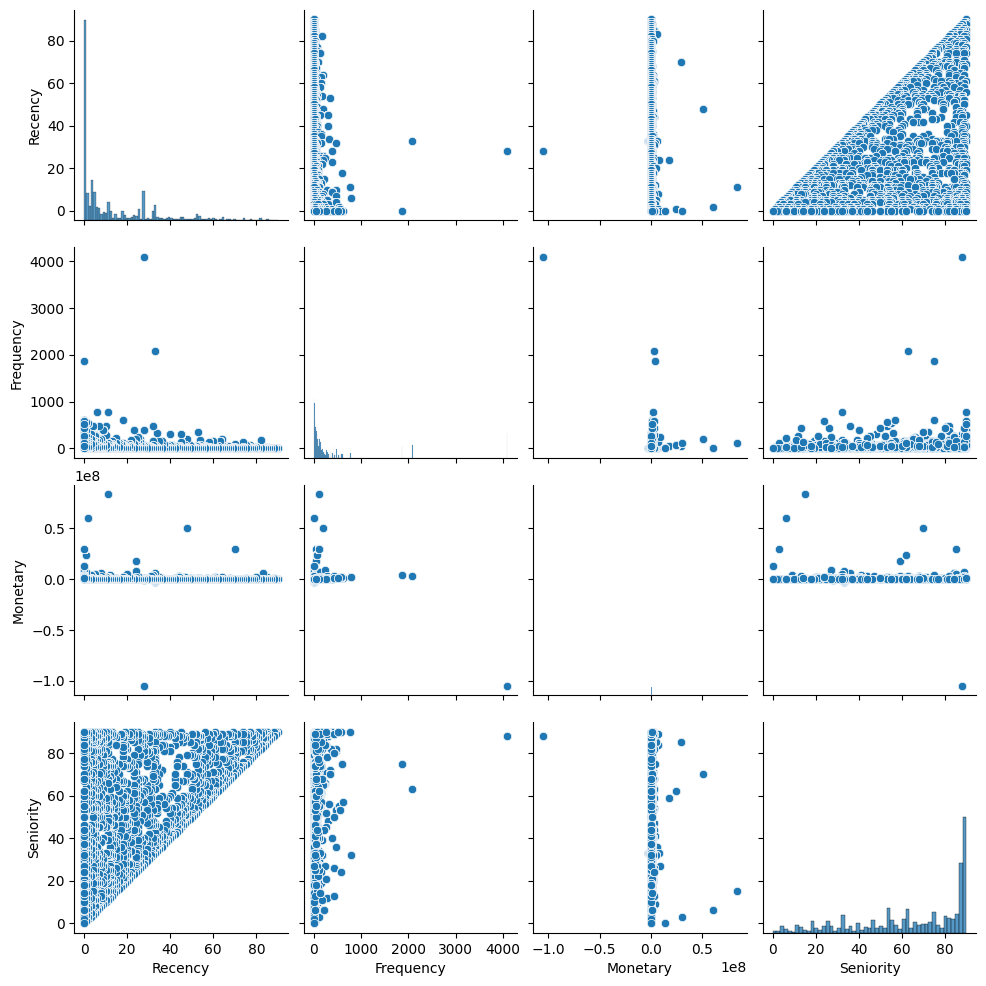

In [64]:
# 1. Constructing a Default Estimator using RFMS formalism
# Convert 'TransactionStartTime' to datetime
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'], errors='coerce')

# Create RFMS features
# Recency: Days since the last transaction
df['Recency'] = (df['TransactionStartTime'].max() - df.groupby('CustomerId')['TransactionStartTime'].transform('max')).dt.days

# Frequency: Total number of transactions per customer
df['Frequency'] = df.groupby('CustomerId')['TransactionId'].transform('count')

# Monetary: Total transaction amount per customer
df['Monetary'] = df.groupby('CustomerId')['Amount'].transform('sum')

# Seniority: Days since the first transaction (engagement duration)
df['Seniority'] = (df['TransactionStartTime'].max() - df.groupby('CustomerId')['TransactionStartTime'].transform('min')).dt.days

# Visualize the RFMS features in pair plots to check distribution
sns.pairplot(df[['Recency', 'Frequency', 'Monetary', 'Seniority']])
plt.show()

#Assigning labels

In [65]:
# Assign Good/Bad Labels Based on RFMS Score


# Calculate RFMS score by multiplying features (adjust the logic based on your understanding)
df['RFMS_Score'] = df['Recency'] * df['Frequency'] * df['Monetary'] * df['Seniority']

# Define a threshold to classify users as 'good' or 'bad'
# Adjust the threshold based on your RFMS analysis (visualize to understand the distribution first)
threshold = df['RFMS_Score'].quantile(0.5)  # You can adjust this threshold
df['RiskLabel'] = df['RFMS_Score'].apply(lambda x: 'bad' if x < threshold else 'good')

# Check the distribution of good and bad users
display(df['RiskLabel'].value_counts())

,count
RiskLabel,
good,47833
bad,47829


#WoE Binning

In [66]:
# 2. Perform WoE Binning

# Perform WoE binning for RFMS features
features_to_bin = ['Recency', 'Frequency', 'Monetary', 'Seniority']

# WoE binning for RFMS features based on 'RiskLabel'
bins = sc.woebin(df, y='RiskLabel', x=features_to_bin)

# Apply WoE binning to the dataset
df_woe = sc.woebin_ply(df, bins)

# View the transformed dataset with WoE features
display(df_woe.head())

[INFO] creating woe binning ...


/usr/local/lib/python3.12/dist-packages/scorecardpy/condition_fun.py:141: UserWarning: The positive value in "RiskLabel" was replaced by 1 and negative value by 0.
  warnings.warn("The positive value in \"{}\" was replaced by 1 and negative value by 0.".format(y))
/usr/local/lib/python3.12/dist-packages/scorecardpy/condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
/usr/local/lib/python3.12/dist-packages/scorecardpy/condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,

[INFO] converting into woe values ...


,AccountId,CurrencyCode,ChannelId,ProviderId,TransactionId,FraudResult,RiskLabel,PricingStrategy,SubscriptionId,CustomerId,...,Value,RFMS_Score,TransactionStartTime,BatchId,Amount,ProductId,Seniority_woe,Frequency_woe,Monetary_woe,Recency_woe
0,AccountId_3957,UGX,ChannelId_3,ProviderId_6,TransactionId_76871,0,bad,2,SubscriptionId_887,CustomerId_4406,...,1000,0.000000e+00,2018-11-15 02:18:49+00:00,BatchId_36123,1000.0,ProductId_10,-0.365797,-0.639772,-0.743699,1.640228
1,AccountId_4841,UGX,ChannelId_2,ProviderId_4,TransactionId_73770,0,bad,2,SubscriptionId_3829,CustomerId_4406,...,20,0.000000e+00,2018-11-15 02:19:08+00:00,BatchId_15642,-20.0,ProductId_6,-0.365797,-0.639772,-0.743699,1.640228
2,AccountId_4229,UGX,ChannelId_3,ProviderId_6,TransactionId_26203,0,bad,2,SubscriptionId_222,CustomerId_4683,...,500,1.458000e+07,2018-11-15 02:44:21+00:00,BatchId_53941,500.0,ProductId_1,-0.365797,1.481383,1.199178,-0.387976
3,AccountId_648,UGX,ChannelId_3,ProviderId_1,TransactionId_380,0,good,2,SubscriptionId_2185,CustomerId_988,...,21800,3.911235e+09,2018-11-15 03:32:55+00:00,BatchId_102363,20000.0,ProductId_21,-0.365797,0.187372,-0.743699,-0.948951
4,AccountId_4841,UGX,ChannelId_2,ProviderId_4,TransactionId_28195,0,good,2,SubscriptionId_3829,CustomerId_988,...,644,3.911235e+09,2018-11-15 03:34:21+00:00,BatchId_38780,-644.0,ProductId_6,-0.365797,0.187372,-0.743699,-0.948951


In [67]:
# 3. Check Information Value (IV)

# Create a DataFrame to store IV values for each feature
iv_df = pd.DataFrame({k: v['total_iv'].iloc[0] for k, v in bins.items()}, index=['IV']).T

# Print IV values for each feature
print("IV values")
display(iv_df)

IV values


,IV
Recency,1.144995
Frequency,0.586235
Monetary,1.023389
Seniority,0.666397


In [68]:
# 4. Save the transformed dataset (optional)
df_woe.to_csv('/content/df_woe.csv', index=False)

In [69]:
df_woe.head()

,AccountId,CurrencyCode,ChannelId,ProviderId,TransactionId,FraudResult,RiskLabel,PricingStrategy,SubscriptionId,CustomerId,...,Value,RFMS_Score,TransactionStartTime,BatchId,Amount,ProductId,Seniority_woe,Frequency_woe,Monetary_woe,Recency_woe
0,AccountId_3957,UGX,ChannelId_3,ProviderId_6,TransactionId_76871,0,bad,2,SubscriptionId_887,CustomerId_4406,...,1000,0.000000e+00,2018-11-15 02:18:49+00:00,BatchId_36123,1000.0,ProductId_10,-0.365797,-0.639772,-0.743699,1.640228
1,AccountId_4841,UGX,ChannelId_2,ProviderId_4,TransactionId_73770,0,bad,2,SubscriptionId_3829,CustomerId_4406,...,20,0.000000e+00,2018-11-15 02:19:08+00:00,BatchId_15642,-20.0,ProductId_6,-0.365797,-0.639772,-0.743699,1.640228
2,AccountId_4229,UGX,ChannelId_3,ProviderId_6,TransactionId_26203,0,bad,2,SubscriptionId_222,CustomerId_4683,...,500,1.458000e+07,2018-11-15 02:44:21+00:00,BatchId_53941,500.0,ProductId_1,-0.365797,1.481383,1.199178,-0.387976
3,AccountId_648,UGX,ChannelId_3,ProviderId_1,TransactionId_380,0,good,2,SubscriptionId_2185,CustomerId_988,...,21800,3.911235e+09,2018-11-15 03:32:55+00:00,BatchId_102363,20000.0,ProductId_21,-0.365797,0.187372,-0.743699,-0.948951
4,AccountId_4841,UGX,ChannelId_2,ProviderId_4,TransactionId_28195,0,good,2,SubscriptionId_3829,CustomerId_988,...,644,3.911235e+09,2018-11-15 03:34:21+00:00,BatchId_38780,-644.0,ProductId_6,-0.365797,0.187372,-0.743699,-0.948951


#EDA

In [12]:
from google.colab import files
uploaded = files.upload()

Saving Credit_Risk_Model.csv to Credit_Risk_Model (1).csv


In [13]:
import pandas as pd

df = pd.read_csv(list(uploaded.keys())[0]) # load uploaded file
df.to_csv('/content/cleaned_data.csv', index=False) # save new file

print("👍 cleaned_data.csv is now saved in /content/")

👍 cleaned_data.csv is now saved in /content/


In [14]:
# Display basic information
print("DataFrame Info:")
display(df_woe.info())

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   AccountId             95662 non-null  object             
 1   CurrencyCode          95662 non-null  object             
 2   ChannelId             95662 non-null  object             
 3   ProviderId            95662 non-null  object             
 4   TransactionId         95662 non-null  object             
 5   FraudResult           95662 non-null  int64              
 6   RiskLabel             95662 non-null  object             
 7   PricingStrategy       95662 non-null  int64              
 8   SubscriptionId        95662 non-null  object             
 9   CustomerId            95662 non-null  object             
 10  ProductCategory       95662 non-null  object             
 11  CountryCode           95662 non-null  int64        

None

In [15]:
# visualize the first few rows
print("\nFirst 5 Rows:")
display(df_woe.head())


First 5 Rows:


,AccountId,CurrencyCode,ChannelId,ProviderId,TransactionId,FraudResult,RiskLabel,PricingStrategy,SubscriptionId,CustomerId,...,Value,RFMS_Score,TransactionStartTime,BatchId,Amount,ProductId,Seniority_woe,Frequency_woe,Monetary_woe,Recency_woe
0,AccountId_3957,UGX,ChannelId_3,ProviderId_6,TransactionId_76871,0,bad,2,SubscriptionId_887,CustomerId_4406,...,1000,0.000000e+00,2018-11-15 02:18:49+00:00,BatchId_36123,1000.0,ProductId_10,-0.365797,-0.639772,-0.743699,1.640228
1,AccountId_4841,UGX,ChannelId_2,ProviderId_4,TransactionId_73770,0,bad,2,SubscriptionId_3829,CustomerId_4406,...,20,0.000000e+00,2018-11-15 02:19:08+00:00,BatchId_15642,-20.0,ProductId_6,-0.365797,-0.639772,-0.743699,1.640228
2,AccountId_4229,UGX,ChannelId_3,ProviderId_6,TransactionId_26203,0,bad,2,SubscriptionId_222,CustomerId_4683,...,500,1.458000e+07,2018-11-15 02:44:21+00:00,BatchId_53941,500.0,ProductId_1,-0.365797,1.481383,1.199178,-0.387976
3,AccountId_648,UGX,ChannelId_3,ProviderId_1,TransactionId_380,0,good,2,SubscriptionId_2185,CustomerId_988,...,21800,3.911235e+09,2018-11-15 03:32:55+00:00,BatchId_102363,20000.0,ProductId_21,-0.365797,0.187372,-0.743699,-0.948951
4,AccountId_4841,UGX,ChannelId_2,ProviderId_4,TransactionId_28195,0,good,2,SubscriptionId_3829,CustomerId_988,...,644,3.911235e+09,2018-11-15 03:34:21+00:00,BatchId_38780,-644.0,ProductId_6,-0.365797,0.187372,-0.743699,-0.948951


In [16]:
# visualize column names to confirm
print("\nColumn Names:")
display(df_woe.columns.tolist())


Column Names:


['AccountId',
 'CurrencyCode',
 'ChannelId',
 'ProviderId',
 'TransactionId',
 'FraudResult',
 'RiskLabel',
 'PricingStrategy',
 'SubscriptionId',
 'CustomerId',
 'ProductCategory',
 'CountryCode',
 'Value',
 'RFMS_Score',
 'TransactionStartTime',
 'BatchId',
 'Amount',
 'ProductId',
 'Seniority_woe',
 'Frequency_woe',
 'Monetary_woe',
 'Recency_woe']

##Statistics summary

In [17]:
# Summary statistics for numerical features
print("Summary Statistics (Numerical):")
display(df_woe.describe())

Summary Statistics (Numerical):


,FraudResult,PricingStrategy,CountryCode,Value,RFMS_Score,Amount,Seniority_woe,Frequency_woe,Monetary_woe,Recency_woe
count,95662.000000,95662.000000,95662.0,9.566200e+04,9.566200e+04,9.566200e+04,95662.000000,95662.000000,95662.000000,95662.000000
mean,0.002018,2.255974,256.0,9.900584e+03,-4.482603e+13,6.717846e+03,0.104923,0.035341,-0.047015,0.070640
std,0.044872,0.732924,0.0,1.231221e+05,2.140410e+14,1.233068e+05,0.965312,0.808607,1.149306,1.152904
min,0.000000,0.000000,256.0,2.000000e+00,-1.057415e+15,-1.000000e+06,-0.365797,-0.639772,-3.102668,-0.948951
25%,0.000000,2.000000,256.0,2.750000e+02,0.000000e+00,-5.000000e+01,-0.365797,-0.639772,-0.743699,-0.948951
50%,0.000000,2.000000,256.0,1.000000e+03,9.481467e+08,1.000000e+03,-0.365797,-0.248778,0.203458,-0.387976
75%,0.000000,2.000000,256.0,5.000000e+03,1.593879e+10,2.800000e+03,0.309000,1.050385,1.199178,1.640228
max,1.000000,4.000000,256.0,9.880000e+06,3.499446e+13,9.880000e+06,2.560780,1.481383,1.199178,1.640228


In [19]:
# Summary statistics for categorical features
print("\nSummary Statistics (Categorical):")
# Update categorical_columns to use WOE transformed columns and existing categorical features
categorical_columns = ['CurrencyCode', 'PricingStrategy', 'FraudResult', 'ProviderId_woe',
                       'ProductCategory_woe', 'ChannelId_woe']

for col in categorical_columns:
    print(f"\nValue Counts for {col}:")
    print(df[col].value_counts())


Summary Statistics (Categorical):

Value Counts for CurrencyCode:
CurrencyCode
UGX    95662
Name: count, dtype: int64

Value Counts for PricingStrategy:
PricingStrategy
2    79848
4    13562
1     1867
0      385
Name: count, dtype: int64

Value Counts for FraudResult:
FraudResult
0    95469
1      193
Name: count, dtype: int64

Value Counts for ProviderId_woe:


KeyError: 'ProviderId_woe'

##Distribution of Numerical Features

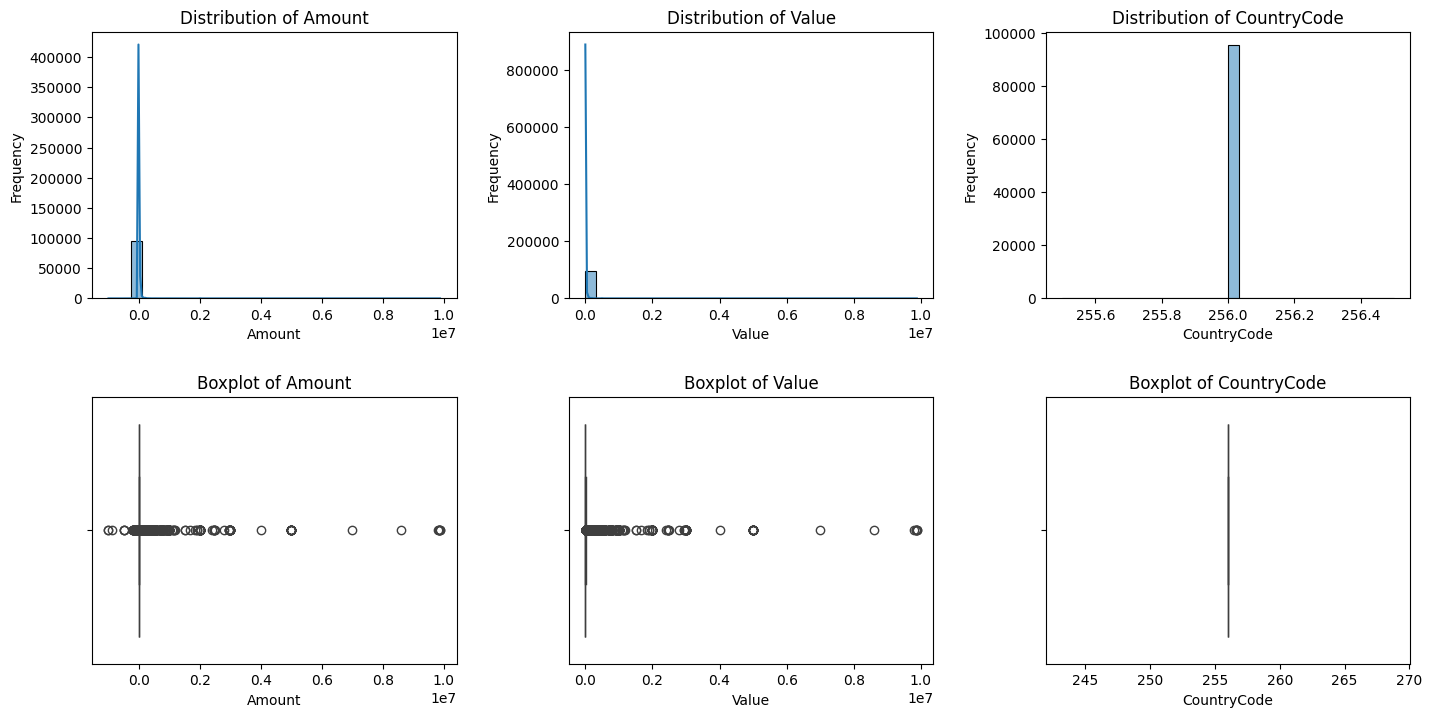

In [20]:
# List of numerical columns
numerical_columns = ['Amount', 'Value', 'CountryCode']

fig, axes = plt.subplots(2, len(numerical_columns), figsize=(15, 8))  # 2 rows, len(numerical_columns) columns
fig.tight_layout(pad=5.0)

for i, col in enumerate(numerical_columns):
    sns.histplot(df_woe[col], kde=True, bins=30, ax=axes[0, i])
    axes[0, i].set_title(f'Distribution of {col}')
    axes[0, i].set_xlabel(col)
    axes[0, i].set_ylabel('Frequency')

for i, col in enumerate(numerical_columns):
    sns.boxplot(x=df_woe[col], ax=axes[1, i])
    axes[1, i].set_title(f'Boxplot of {col}')
    axes[1, i].set_xlabel(col)

plt.show()

##Distribution of Categorical Features

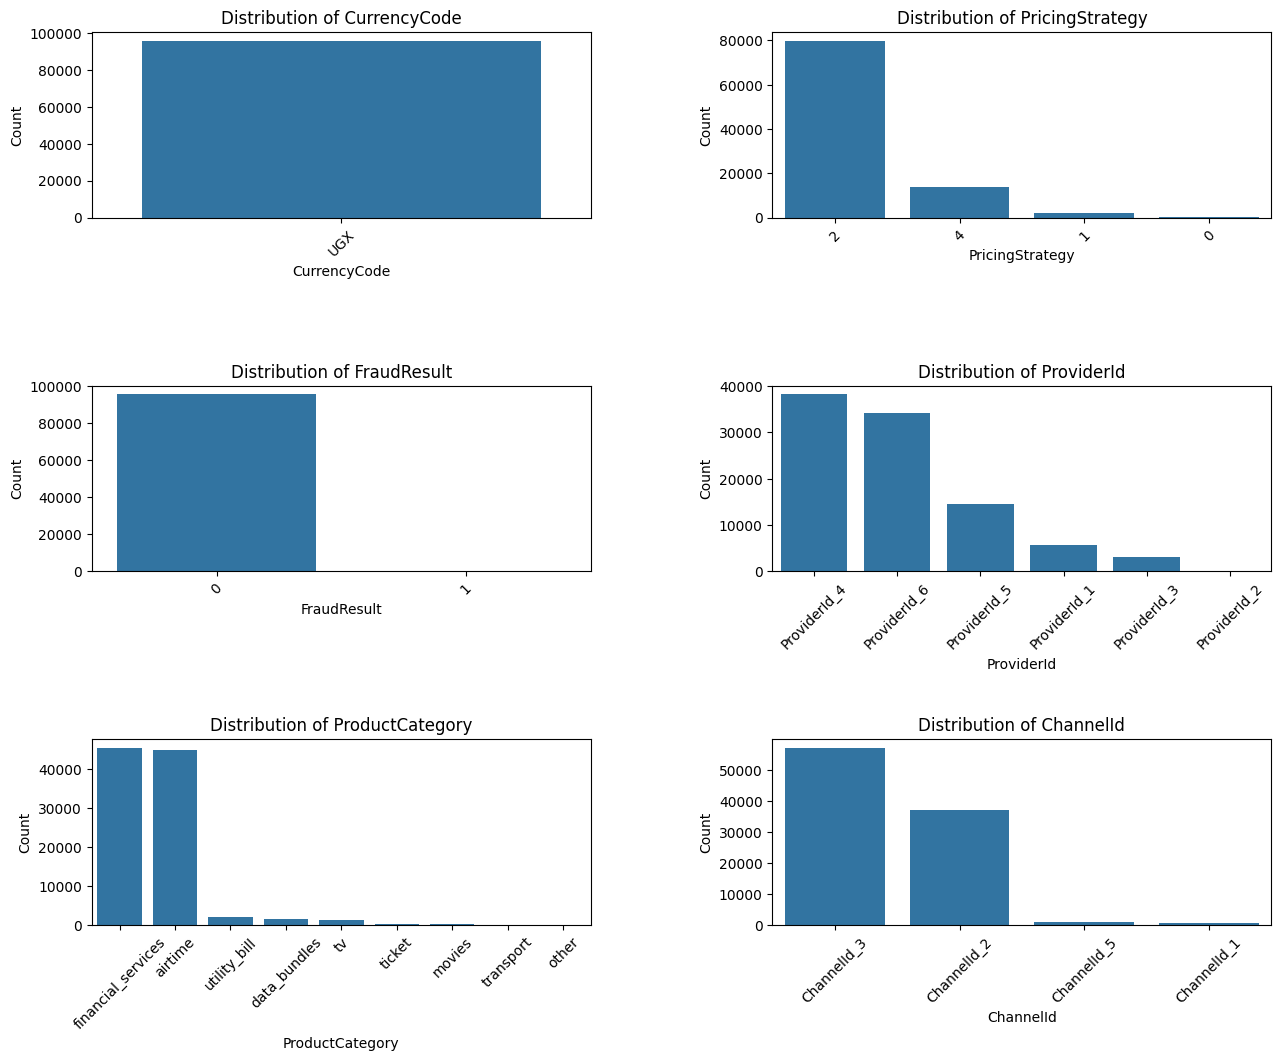

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of categorical columns excluding identifiers
categorical_columns = ['CurrencyCode', 'PricingStrategy', 'FraudResult', 'ProviderId',
                       'ProductCategory', 'ChannelId']

n_cols = 2
n_rows = (len(categorical_columns) + n_cols - 1) // n_cols  # Calculate required rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 12))
fig.tight_layout(pad=10.0)

# Flatten axes array in case of multiple rows
axes = axes.flatten()

# Plot countplots
for i, col in enumerate(categorical_columns):
    sns.countplot(data=df_woe, x=col, order=df_woe[col].value_counts().index, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

# Hide any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

##Correlation Analysis

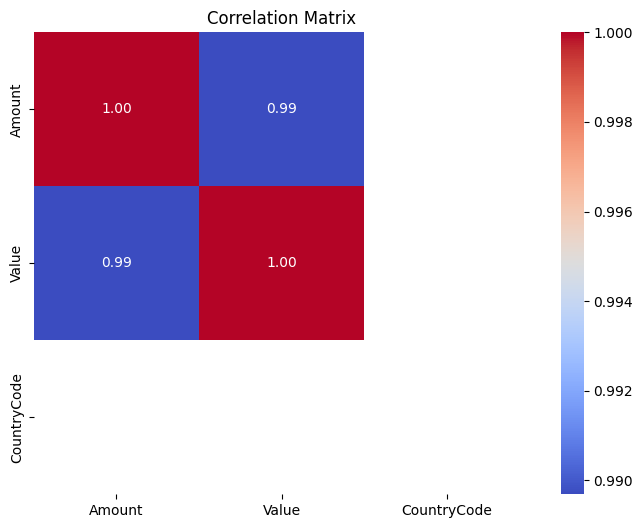

In [23]:
# Compute correlation matrix
corr_matrix = df_woe[numerical_columns].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

##FINE CLASSING CODE

In [24]:
import pandas as pd
import numpy as np

# Fine classing using quantiles
df['amount_fine_bin'] = pd.qcut(df['Amount'], q=10, duplicates='drop')

# Fraud rate per fine bin
fine_table = df.groupby('amount_fine_bin')['FraudResult'].agg(
    total='count',
    fraud_rate='mean'
).reset_index()

print(fine_table)

           amount_fine_bin  total  fraud_rate
0  (-1000000.001, -2500.0]   9589    0.000417
1        (-2500.0, -100.0]   9981    0.000100
2          (-100.0, -50.0]  10523    0.000000
3           (-50.0, 200.0]   8195    0.000000
4          (200.0, 1000.0]  23837    0.000042
5         (1000.0, 2000.0]   8859    0.000000
6         (2000.0, 5000.0]   8457    0.000000
7        (5000.0, 10000.0]  10051    0.000000
8     (10000.0, 9880000.0]   6170    0.030308


/tmp/ipython-input-1372411163.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fine_table = df.groupby('amount_fine_bin')['FraudResult'].agg(


##COARSE CLASSING CODE

In [28]:
# Calculate quantiles
q33 = df['Amount'].quantile(0.33)
q66 = df['Amount'].quantile(0.66)
max_val = df['Amount'].max()

# Create bins safely (remove duplicates + sort)
bins = sorted(set([-1, q33, q66, max_val]))

# Create labels dynamically
labels = ['Low', 'Medium', 'High'][:len(bins)-1]

# Apply cut
df['amount_coarse_bin'] = pd.cut(
    df['Amount'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# Check result
coarse_table = df.groupby('amount_coarse_bin')['FraudResult'].mean().reset_index()
print(coarse_table)

  amount_coarse_bin  FraudResult
0               Low     0.000000
1            Medium     0.000040
2              High     0.005775


/tmp/ipython-input-3774432193.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  coarse_table = df.groupby('amount_coarse_bin')['FraudResult'].mean().reset_index()


In [29]:
# View fine bin fraud rate
fine_table = df.groupby('amount_fine_bin')['FraudResult'].mean().reset_index()
print(fine_table)

           amount_fine_bin  FraudResult
0  (-1000000.001, -2500.0]     0.000417
1        (-2500.0, -100.0]     0.000100
2          (-100.0, -50.0]     0.000000
3           (-50.0, 200.0]     0.000000
4          (200.0, 1000.0]     0.000042
5         (1000.0, 2000.0]     0.000000
6         (2000.0, 5000.0]     0.000000
7        (5000.0, 10000.0]     0.000000
8     (10000.0, 9880000.0]     0.030308


/tmp/ipython-input-3529962907.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fine_table = df.groupby('amount_fine_bin')['FraudResult'].mean().reset_index()


##Apply WOE in coarse bin

In [30]:
import numpy as np

# Total good & bad
total_bad = df['FraudResult'].sum()
total_good = len(df) - total_bad

# WOE table
woe_table = df.groupby(
    'amount_coarse_bin',
    observed=True
)['FraudResult'].agg(
    bad='sum',
    total='count'
).reset_index()

# Good count
woe_table['good'] = woe_table['total'] - woe_table['bad']

# Distribution
woe_table['dist_bad'] = woe_table['bad'] / total_bad
woe_table['dist_good'] = woe_table['good'] / total_good

# WOE formula
woe_table['WOE'] = np.log(woe_table['dist_good'] / woe_table['dist_bad'])

print(woe_table)

  amount_coarse_bin  bad  total   good  dist_bad  dist_good       WOE
0               Low    0   6634   6634  0.000000   0.069489       inf
1            Medium    1  25090  25089  0.005181   0.262797  3.926318
2              High  187  32383  32196  0.968912   0.337240 -1.055378


#Feature Engenearing

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
!pip install scorecardpy

In [ ]:
import scorecardpy as sc

In [ ]:
# Load your dataset (replace 'your_file.csv' with your actual file path)
df = pd.read_csv('/content/cleaned_data.csv')

##1. Create Aggregate Features

In [ ]:
# Total Transaction Amount per customer
df['TotalTransactionAmount'] = df.groupby('CustomerId')['Amount'].transform('sum')

# Average Transaction Amount per customer
df['AverageTransactionAmount'] = df.groupby('CustomerId')['Amount'].transform('mean')

# Transaction Count per customer
df['TransactionCount'] = df.groupby('CustomerId')['TransactionId'].transform('count')

# Standard Deviation of Transaction Amounts per customer
df['TransactionAmountStd'] = df.groupby('CustomerId')['Amount'].transform('std').fillna(0)

##2. Extract Time-Based Features

In [ ]:
df['TransactionStartTime'] = pd.to_datetime(df['TransactionStartTime'], errors='coerce')

df['TransactionHour'] = df['TransactionStartTime'].dt.hour
df['TransactionDay'] = df['TransactionStartTime'].dt.day
df['TransactionMonth'] = df['TransactionStartTime'].dt.month
df['TransactionYear'] = df['TransactionStartTime'].dt.year

##3. Encode Categorical Variables using WOE

In [ ]:
# 3. Encode Categorical Variables using scorecardpy's WOE
# ---------------------
# Assuming 'FraudResult' is the target variable and 'ProductCategory', 'ProviderId', 'ChannelId' are the features
features = ['ProductCategory', 'ProviderId', 'ChannelId']

# Calculate the WOE and IV for each feature
bins = sc.woebin(df, y='FraudResult', x=features)

# Apply the WOE transformation to the dataset
df_woe = sc.woebin_ply(df, bins)

[INFO] creating woe binning ...


/usr/local/lib/python3.12/dist-packages/scorecardpy/condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
/usr/local/lib/python3.12/dist-packages/scorecardpy/condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
/usr/local/lib/python3.12/dist-packages/scorecardpy/condition_fun.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is

[INFO] converting into woe values ...


##4. Handle Missing Values

In [ ]:
# Fill missing numerical columns with median
for col in ['Amount', 'Value', 'TotalTransactionAmount', 'AverageTransactionAmount', 'TransactionAmountStd']:
    df_woe[col].fillna(df_woe[col].median(), inplace=True)

# Handle missing values for categorical WOE columns
for col in ['ProductCategory_woe', 'CurrencyCode', 'ProviderId_woe', 'ChannelId_woe']:
    df_woe[col].fillna(df_woe[col].mode()[0], inplace=True)

/tmp/ipython-input-551821202.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_woe[col].fillna(df_woe[col].median(), inplace=True)
/tmp/ipython-input-551821202.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

##5. Normalize/Standardize Numerical Features

In [ ]:
# Standardize (mean=0, std=1) the numerical features
scaler = StandardScaler()
df_woe[['Amount', 'Value', 'TotalTransactionAmount', 'AverageTransactionAmount', 'TransactionAmountStd']] = scaler.fit_transform(
    df_woe[['Amount', 'Value', 'TotalTransactionAmount', 'AverageTransactionAmount', 'TransactionAmountStd']]
)

In [ ]:
# Final check of the dataset
print(df_woe.head())

          BatchId        TransactionId  TransactionMonth     Value  \
0   BatchId_36123  TransactionId_76871                11 -0.072291   
1   BatchId_15642  TransactionId_73770                11 -0.080251   
2   BatchId_53941  TransactionId_26203                11 -0.076352   
3  BatchId_102363    TransactionId_380                11  0.096648   
4   BatchId_38780  TransactionId_28195                11 -0.075183   

       TransactionStartTime CurrencyCode  PricingStrategy       CustomerId  \
0 2018-11-15 02:18:49+00:00          UGX                2  CustomerId_4406   
1 2018-11-15 02:19:08+00:00          UGX                2  CustomerId_4406   
2 2018-11-15 02:44:21+00:00          UGX                2  CustomerId_4683   
3 2018-11-15 03:32:55+00:00          UGX                2   CustomerId_988   
4 2018-11-15 03:34:21+00:00          UGX                2   CustomerId_988   

   CountryCode       AccountId  ...  TransactionCount  TransactionYear  \
0          256  AccountId_3957  ... 

In [ ]:
# Save the processed dataset to CSV (optional)
df_woe.to_csv('/content/Credit_Risk_Model.csv', index=False)

##VIF

In [32]:
# Only numeric columns
X = df.select_dtypes(include=['int64','float64'])

In [33]:
import numpy as np

X = X.replace([np.inf, -np.inf], np.nan)
X = X.dropna()

In [34]:
# Remove constant columns
X = X.loc[:, X.nunique() > 1]

In [35]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [
    variance_inflation_factor(X.values, i)
    for i in range(X.shape[1])
]

print(vif_data)

           Feature        VIF
0           Amount  50.941925
1            Value  51.944946
2  PricingStrategy   1.078115
3      FraudResult   1.477900


In [36]:
high_vif = vif_data[vif_data['VIF'] > 10]['Feature'].tolist()
print("Dropping:", high_vif)

df = df.drop(columns=high_vif)

Dropping: ['Amount', 'Value']


#Model Training

In [38]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pickle  # For saving the model

In [46]:
# Load the dataset (replace 'path_to_your_data.csv' with your actual file path)
df = pd.read_csv('/content/Credit_Risk_Model.csv')
df = df.drop(columns=['TransactionId','SubscriptionId','AccountId','ProductId','BatchId',
                      'CustomerId','CurrencyCode','CountryCode','TransactionStartTime',
                      'TransactionYear','TransactionDay','PricingStrategy','TransactionHour','TransactionMonth'], errors='ignore')
print(df.columns)

Index(['ProviderId', 'ProductCategory', 'ChannelId', 'Amount', 'Value',
       'FraudResult'],
      dtype='object')


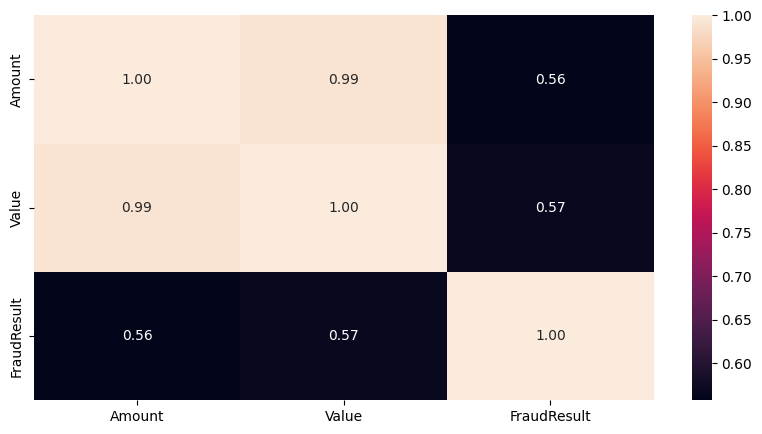

In [48]:
# Using 'FraudResult' as the target, which is already 0/1 encoded.
# No need for LabelEncoder as 'FraudResult' is already numerical.
y = df['FraudResult']  # Target variable

# Drop the target variable from features if it's still present
X = df.drop(columns=['FraudResult'])  # Features

plt.figure(figsize=(10, 5))

# Select only numerical columns for correlation calculation
numeric_df = df.select_dtypes(include=['number'])
correlation_matrix = numeric_df.corr()

sns.heatmap(correlation_matrix, annot=True, fmt='.2f')
plt.show()

In [51]:
df = df.drop(columns=['Amount']) # RFMS_Score and TransactionCount are not in the current df
print(df.columns)

Index(['ProviderId', 'ProductCategory', 'ChannelId', 'Value', 'FraudResult'], dtype='object')


In [70]:
# Load the fully engineered dataset
df_woe = pd.read_csv('/content/Credit_Risk_Model.csv')

# Debug: Check columns present in the reloaded df_woe
print("Columns in reloaded df_woe:", df_woe.columns.tolist())

# Split data into features (X) and target variable (y)
y = df_woe['FraudResult']  # Target variable

# Define all possible engineered features
all_possible_X_columns = [
    'Amount', 'Value', 'PricingStrategy',
    'TotalTransactionAmount', 'AverageTransactionAmount', 'TransactionAmountStd',
    'TransactionHour', 'TransactionDay', 'TransactionMonth', 'TransactionYear',
    'ProviderId_woe', 'ProductCategory_woe', 'ChannelId_woe'
]

# Filter X_columns to only include those present in the reloaded df_woe
X_columns = [col for col in all_possible_X_columns if col in df_woe.columns]

X = df_woe[X_columns] # Features

# Feature scaling using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Logistic Regression with Lasso for feature selection
lasso = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)  # L1 regularization
lasso.fit(X_scaled, y)

# Get the non-zero coefficients (selected features)
coef = pd.Series(lasso.coef_[0], index=X.columns)
selected_features_lasso = coef[coef != 0].index
print("Selected Features using Lasso Regression:")
print(selected_features_lasso)

Columns in reloaded df_woe: ['TransactionId', 'BatchId', 'AccountId', 'SubscriptionId', 'CustomerId', 'CurrencyCode', 'CountryCode', 'ProviderId', 'ProductId', 'ProductCategory', 'ChannelId', 'Amount', 'Value', 'TransactionStartTime', 'PricingStrategy', 'FraudResult']
Selected Features using Lasso Regression:
Index(['Amount', 'Value', 'PricingStrategy'], dtype='object')


In [71]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# Train logistic model
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

# Predictions
y_pred = log_model.predict(X_test)
y_prob = log_model.predict_proba(X_test)[:,1]

# Metrics
print("Logistic Regression Performance")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

Logistic Regression Performance
Accuracy: 0.9979093348200285
ROC-AUC: 0.9982148210486775
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28641
           1       0.47      0.33      0.39        58

    accuracy                           1.00     28699
   macro avg       0.74      0.66      0.69     28699
weighted avg       1.00      1.00      1.00     28699



In [ ]:
# Filter the dataset with the selected features
X_selected = df[selected_features_lasso]
# Split the data: 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

In [ ]:
# Initialize the models
rf_model = RandomForestClassifier(random_state=42)
gbm_model = GradientBoostingClassifier(random_state=42)

# Random Forest Parameter Grid
rf_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid Search for Random Forest
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=5, n_jobs=-1, verbose=2)
rf_grid_search.fit(X_train, y_train)

print("Best Random Forest Parameters:", rf_grid_search.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Random Forest Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}


In [ ]:
# Gradient Boosting Parameter Grid
gbm_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Random Search for Gradient Boosting
gbm_random_search = RandomizedSearchCV(estimator=gbm_model, param_distributions=gbm_param_grid, n_iter=50, cv=5, random_state=42, n_jobs=-1, verbose=2)
gbm_random_search.fit(X_train, y_train)

print("Best GBM Parameters:", gbm_random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best GBM Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 5, 'learning_rate': 0.01}


In [ ]:
# Function to evaluate model performance
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")

    return roc_auc

In [ ]:
# Evaluate Random Forest
print("Random Forest Performance:")
rf_roc_auc = evaluate_model(rf_grid_search, X_test, y_test)
# Evaluate Gradient Boosting
print("\nGradient Boosting Performance:")
gbm_roc_auc = evaluate_model(gbm_random_search, X_test, y_test)

Random Forest Performance:
Accuracy: 0.9993
Precision: 0.7937
Recall: 0.8929
F1 Score: 0.8403
ROC-AUC: 0.9996

Gradient Boosting Performance:
Accuracy: 0.9997
Precision: 0.9796
Recall: 0.8571
F1 Score: 0.9143
ROC-AUC: 0.9910


In [ ]:
cv_scores_rf = cross_val_score(rf_grid_search, X, y, cv=5)
cv_scores_gbm = cross_val_score(gbm_random_search, X, y, cv=5)
print("\n")
print("Random Forest CV Average Score:", cv_scores_rf.mean())
print("GBM CV Average Score:", cv_scores_gbm.mean())

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [72]:
from sklearn.metrics import roc_auc_score, roc_curve

# Predicted probability
y_pred_prob = log_model.predict_proba(X_test)[:,1]

In [73]:
auc = roc_auc_score(y_test, y_pred_prob)
print("AUC:", auc)

AUC: 0.9982148210486775


In [74]:
gini = 2*auc - 1
print("Gini:", gini)

Gini: 0.9964296420973551


In [75]:
import numpy as np

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
ks = max(tpr - fpr)
print("KS Statistic:", ks)

KS Statistic: 0.972109551173926


##Bin-wise Calibration

In [76]:
import pandas as pd
import numpy as np

# Probability prediction (apna trained model use karo)
y_pred_prob = log_model.predict_proba(X_test)[:,1]   # ya rf_model / gb_model

# Create calibration dataframe
cal_df = pd.DataFrame({
    'actual': y_test,
    'pred_prob': y_pred_prob
})

# Create decile bins
cal_df['score_bin'] = pd.qcut(cal_df['pred_prob'], 10, duplicates='drop')

# Bin-wise stats
cal_table = cal_df.groupby('score_bin').agg(
    total=('actual','count'),
    actual_rate=('actual','mean'),
    predicted_rate=('pred_prob','mean')
).reset_index()

print(cal_table)

                             score_bin  total  actual_rate  predicted_rate
0  (0.00013759999999999998, 0.0002767]   2893     0.000000        0.000245
1               (0.0002767, 0.0007751]   2992     0.000000        0.000608
2               (0.0007751, 0.0007753]   3092     0.000000        0.000775
3               (0.0007753, 0.0007778]   3471     0.000000        0.000777
4               (0.0007778, 0.0007808]   5098     0.000000        0.000781
5               (0.0007808, 0.0007868]   2918     0.000000        0.000785
6               (0.0007868, 0.0008201]   2498     0.000000        0.000802
7               (0.0008201, 0.0008364]   3196     0.000000        0.000831
8                     (0.0008364, 1.0]   2541     0.022826        0.017123


/tmp/ipython-input-596134935.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cal_table = cal_df.groupby('score_bin').agg(


##Population Stability Index (PSI)

In [77]:
def calculate_psi(expected, actual, bins=10):
    breakpoints = np.arange(0, bins+1) / bins
    expected_perc = np.percentile(expected, breakpoints*100)
    actual_perc = np.percentile(actual, breakpoints*100)

    psi_value = 0
    for i in range(len(expected_perc)-1):
        exp_count = np.mean((expected >= expected_perc[i]) & (expected < expected_perc[i+1]))
        act_count = np.mean((actual >= actual_perc[i]) & (actual < actual_perc[i+1]))

        # avoid division by zero
        exp_count = max(exp_count, 0.0001)
        act_count = max(act_count, 0.0001)

        psi_value += (exp_count - act_count) * np.log(exp_count / act_count)

    return psi_value


# PSI on prediction score
train_prob = log_model.predict_proba(X_train)[:,1]
test_prob  = log_model.predict_proba(X_test)[:,1]

psi_score = calculate_psi(train_prob, test_prob)
print("PSI:", psi_score)

PSI: 0.0004751774965742035
